### Dependencies

In [1]:
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import albumentations as albu
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

!pip install segmentation-models
import segmentation_models as sm

Using TensorFlow backend.


     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4436
Validation samples:  1110
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,set
0,c9629d8.jpg,NaN,1082202 658 1083602 658 1085002 658 1086402 65...,1134924 476 1136324 476 1137724 476 1139124 47...,1674 417 3074 417 4474 417 5874 417 7274 417 8...,train
1,e8e25ab.jpg,239 463 1639 463 3039 463 4439 463 5839 463 72...,1029006 350 1030406 350 1031806 350 1033206 35...,NaN,5606 574 7006 574 8406 574 9806 574 11206 574 ...,train
2,31c1874.jpg,959762 410 961162 410 962562 410 963962 410 96...,751962 1228 753362 1228 754762 1228 756162 122...,NaN,NaN,train
3,a396614.jpg,NaN,NaN,17941 239 19341 239 20741 239 22141 239 23541 ...,3030 665 4430 665 5830 665 7230 665 8574 1226 ...,train
4,560dedf.jpg,6555 444 7955 444 8437 897 9355 444 9837 897 1...,NaN,NaN,1409 644 2809 644 4209 644 5609 644 7009 644 8...,train


# Model parameters

In [3]:
BACKBONE = 'resnet18'
BATCH_SIZE = 64
EPOCHS = 15
BASE_LR = 1e-6
MAX_LR = 6e-3
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
EPOCHS_PER_CYCLES = 5
STEP_SIZE = (EPOCHS_PER_CYCLES * (len(X_train) // BATCH_SIZE)) / 2
model_path = '../working/uNet_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)

In [4]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.15),
                             albu.ShiftScaleRotate(rotate_limit=0, p=0.2)
                            ])

### Auxiliary functions

In [5]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path)
            
def get_metrics(model, df, df_images_dest_path, tresholds, min_mask_sizes, set_name='Complete set'):
    column_names = ['Fish', 'Flower', 'Gravel', 'Sugar', set_name]
    index_name = ['Dice Coeff']
    dice = np.zeros((1, N_CLASSES))
    dice_post = np.zeros((1, N_CLASSES))
    
    for i in range(0, df.shape[0], 500):
        batch_score = []
        batch_score_post = []
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=train,
                      batch_size=len(batch_set), 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)

        for index in range(len(batch_idx)):
            class_score = []
            class_score_post = []
            sample_mask = y[index, ]
            sample_pred = preds[index, ]
            for class_index in range(N_CLASSES):
                label_class = sample_mask[..., class_index]
                pred_class = sample_pred[..., class_index]
                pred_class_post = post_process(pred_class, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                dice_score = dice_coefficient(pred_class, label_class)
                dice_score_post = dice_coefficient(pred_class_post, label_class)
                if (pred_class.sum() == 0) & (label_class.sum() == 0):
                    dice_score = 1.
                if (pred_class_post.sum() == 0) & (label_class.sum() == 0):
                    dice_score_post = 1.
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            batch_score.append(class_score)
            batch_score_post.append(class_score_post)
        dice += np.mean(batch_score, axis=0) * ratio
        dice_post += np.mean(batch_score_post, axis=0) * ratio

    dice_class = np.mean(dice, axis=0)
    dice = np.mean(dice_class, axis=0)
    metrics = np.append(dice_class,  dice)
    metrics = pd.DataFrame(metrics.reshape(1, metrics.shape[0]), columns=column_names, index=index_name)
    
    dice_class_post = np.mean(dice_post, axis=0)
    dice_post = np.mean(dice_class_post, axis=0)
    metrics_post = np.append(dice_class_post, dice_post)
    metrics_post = pd.DataFrame(metrics_post.reshape(1, metrics_post.shape[0]), columns=column_names, index=index_name)
    
    return metrics, metrics_post

def plot_metrics(history):
    fig, axes = plt.subplots(4, 1, sharex='col', figsize=(22, 14))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(history['iou_score'], label='Train IOU Score')
    axes[1].plot(history['val_iou_score'], label='Validation IOU Score')
    axes[1].legend(loc='best')
    axes[1].set_title('IOU Score')

    axes[2].plot(history['dice_coef'], label='Train Dice coefficient')
    axes[2].plot(history['val_dice_coef'], label='Validation Dice coefficient')
    axes[2].legend(loc='best')
    axes[2].set_title('Dice coefficient')

    axes[3].plot(history['score'], label='Train F-Score')
    axes[3].plot(history['val_score'], label='Validation F-Score')
    axes[3].legend(loc='best')
    axes[3].set_title('F-Score')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
    
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(self,
                base_lr=0.001,
                max_lr=0.006,
                step_size=2000.,
                mode='triangular',
                gamma=1.,
                scale_fn=None,
                scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2', 'exp_range']:
            raise KeyError("mode must be one of 'triangular', ""'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

## Pre-process data

In [6]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

# Pre-procecss train set
pre_process_set(X_train, preprocess_data)

# Pre-procecss validation set
pre_process_set(X_val, preprocess_data)

# Pre-procecss test set
pre_process_set(test, preprocess_data)

### Data generator

In [7]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, target_df=None, mode='fit', directory=train_images_dest_path,
                 batch_size=BATCH_SIZE, n_channels=CHANNELS, target_size=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, seed=seed, shuffle=True, preprocessing=None, augmentation=None):
        
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.mode = mode
        self.directory = directory
        self.target_df = target_df
        self.target_size = target_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.seed = seed
        self.mask_shape = (1400, 2100)
        self.list_IDs = self.dataframe.index
        
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_Y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.target_size, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            img_path = self.directory + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            img = img.astype(np.float32) / 255.
            
            X[i,] = img

        return X
    
    def __generate_Y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.target_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == img_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.target_size)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, X_batch, Y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], Y_batch[i, ] = self.__random_transform(X_batch[i, ], Y_batch[i, ])
        
        return X_batch, Y_batch
    
    def __random_transform(self, X, Y):
        composed = self.augmentation(image=X, mask=Y)
        X_aug = composed['image']
        Y_aug = composed['mask']
        
        return X_aug, Y_aug
    
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [8]:
model = sm.Unet(encoder_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cyclic_lr = CyclicLR(base_lr=BASE_LR,
                     max_lr=MAX_LR,
                     step_size=STEP_SIZE,
                     mode='exp_range')

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, cyclic_lr]
optimizer = optimizers.Adam(lr=BASE_LR)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "u-vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________

In [9]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15
 - 210s - loss: 1.3207 - dice_coef: 0.2847 - iou_score: 0.1221 - score: 0.1916 - val_loss: 78.8088 - val_dice_coef: 0.1696 - val_iou_score: 0.1942 - val_score: 0.2086
Epoch 2/15
 - 199s - loss: 1.1313 - dice_coef: 0.3714 - iou_score: 0.1470 - score: 0.2206 - val_loss: 2.9742 - val_dice_coef: 0.3809 - val_iou_score: 0.1570 - val_score: 0.2139
Epoch 3/15
 - 196s - loss: 1.1034 - dice_coef: 0.4036 - iou_score: 0.1592 - score: 0.2335 - val_loss: 2.3232 - val_dice_coef: 0.3980 - val_iou_score: 0.1592 - val_score: 0.2152
Epoch 4/15
 - 200s - loss: 1.0866 - dice_coef: 0.4224 - iou_score: 0.1667 - score: 0.2415 - val_loss: 1.2855 - val_dice_coef: 0.3676 - val_iou_score: 0.1350 - val_score: 0.1972
Epoch 5/15
 - 196s - loss: 1.0640 - dice_coef: 0.4438 - iou_score: 0.1750 - score: 0.2505 - val_loss: 1.0662 - val_dice_coef: 0.4467 - val_iou_score: 0.1727 - val_score: 0.2452
Epoch 6/15
 - 200s - loss: 1.0586 - dice_coef: 0.4505 - iou_score: 0.1774 - score: 0.2529 - val_loss: 1.2584 - val

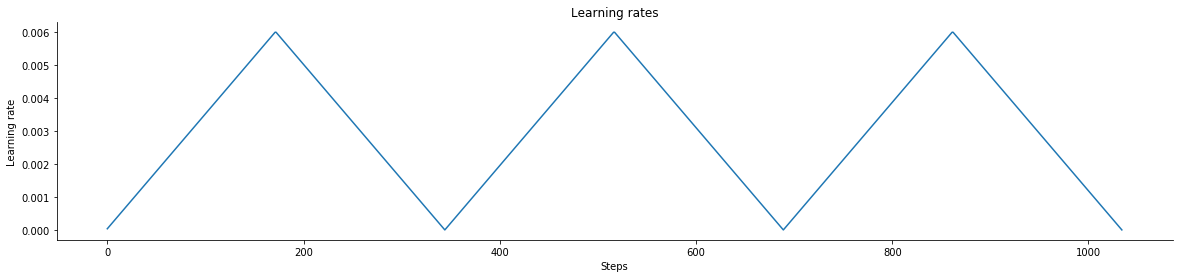

In [10]:
fig = plt.subplots(figsize=(20, 4))

plt.plot(cyclic_lr.history['lr'])
plt.title('Learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

## Model loss graph

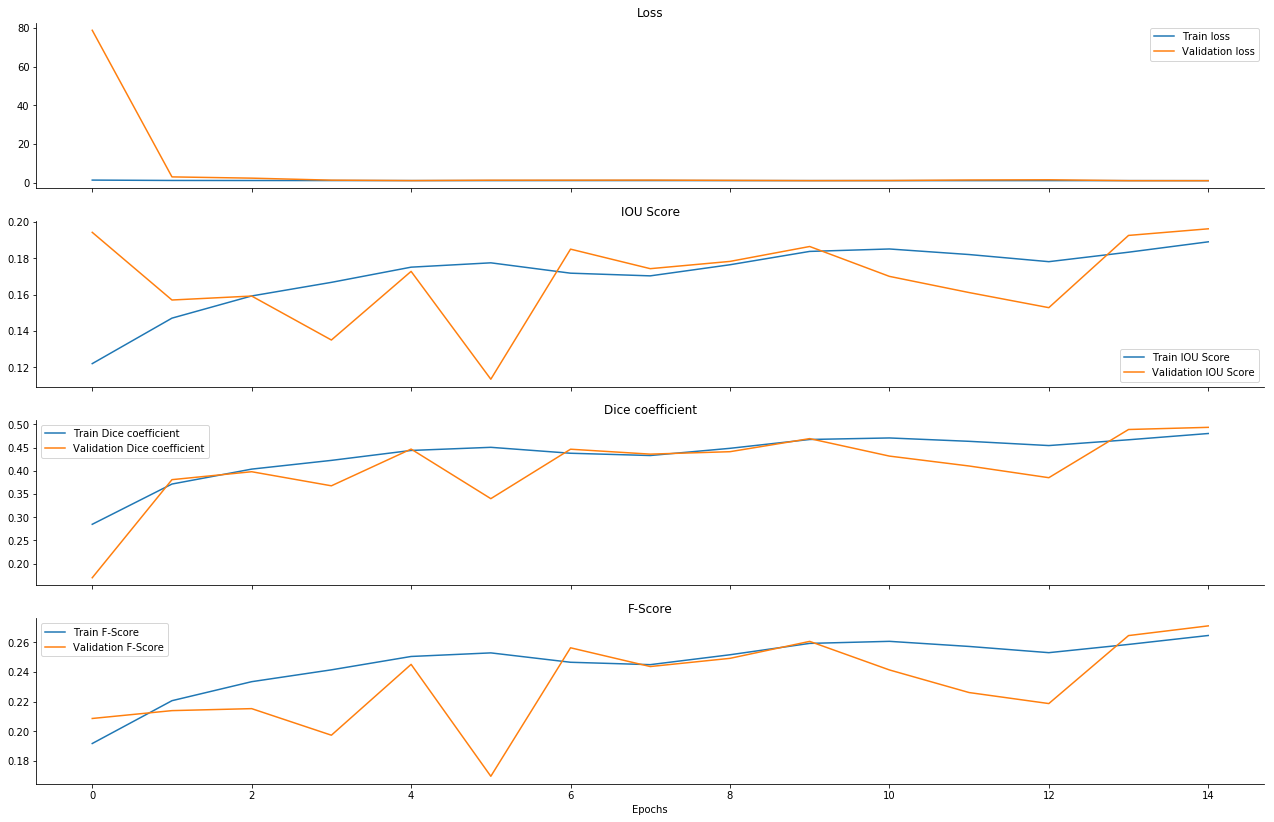

In [11]:
plot_metrics(history)

# Threshold and mask size tunning

In [12]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
mask_grid = [0, 500, 1000, 5000, 7500, 10000, 15000]
threshold_grid = np.arange(.5, 1, .05)
metrics = []

for class_index in range(N_CLASSES):
    for threshold in threshold_grid:
        for mask_size in mask_grid:
            metrics.append([class_index, threshold, mask_size, 0])

metrics_df = pd.DataFrame(metrics, columns=['Class', 'Threshold', 'Mask size', 'Dice'])

for i in range(0, X_val.shape[0], 500):
    batch_score = []
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for threshold in threshold_grid:
            threshold_score = []
            for mask_size in mask_grid:
                mask_score = []
                for index in range(len(batch_idx)):
                    label_mask = label_class[index, ]
                    pred_mask = pred_class[index, ]
                    pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                    dice_score = dice_coefficient(pred_mask, label_mask)
                    if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                        dice_score = 1.
                    mask_score.append(dice_score)
                metrics_df.loc[(metrics_df['Class'] == class_index) & (metrics_df['Threshold'] == threshold) & 
                               (metrics_df['Mask size'] == mask_size), 'Dice'] += np.mean(mask_score) * ratio
                threshold_score.append(np.mean(mask_score) * ratio)

metrics_df_0 = metrics_df[metrics_df['Class'] == 0]
metrics_df_1 = metrics_df[metrics_df['Class'] == 1]
metrics_df_2 = metrics_df[metrics_df['Class'] == 2]
metrics_df_3 = metrics_df[metrics_df['Class'] == 3]

optimal_values_0 = metrics_df_0.loc[metrics_df_0['Dice'].idxmax()].values
optimal_values_1 = metrics_df_1.loc[metrics_df_1['Dice'].idxmax()].values
optimal_values_2 = metrics_df_2.loc[metrics_df_2['Dice'].idxmax()].values
optimal_values_3 = metrics_df_3.loc[metrics_df_3['Dice'].idxmax()].values

best_tresholds = [optimal_values_0[1], optimal_values_1[1], optimal_values_2[1], optimal_values_3[1]]
best_masks = [optimal_values_0[2], optimal_values_1[2], optimal_values_2[2], optimal_values_3[2]]
best_dices = [optimal_values_0[3], optimal_values_1[3], optimal_values_2[3], optimal_values_3[3]]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))

Fish   treshold=0.70 mask size=5000 Dice=0.586
Flower treshold=0.55 mask size=5000 Dice=0.732
Gravel treshold=0.50 mask size=7500 Dice=0.580
Sugar  treshold=0.55 mask size=5000 Dice=0.570


# Model evaluation

## Without post processing

In [13]:
# Train metrics
train_metrics, train_metrics_post = get_metrics(model, X_train, train_images_dest_path, best_tresholds, best_masks, 'Train')
display(train_metrics)

# Validation metrics
validation_metrics, validation_metrics_post = get_metrics(model, X_val, validation_images_dest_path, best_tresholds, best_masks, 'Validation')
display(validation_metrics)

,Fish,Flower,Gravel,Sugar,Train
Dice Coeff,0.214878,0.196685,0.218625,0.248951,0.219785


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.213672,0.192164,0.219522,0.248835,0.218548


## With post processing

In [14]:
display(train_metrics_post)
display(validation_metrics_post)

,Fish,Flower,Gravel,Sugar,Train
Dice Coeff,0.57602,0.761983,0.588501,0.568508,0.623753


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.585531,0.731922,0.580341,0.570124,0.61698


# Apply model to test set

In [15]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_dest_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [16]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,65336 22 65686 22 66036 22 66377 34 66727 34 6...
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,36 272 386 272 736 272 1086 272 1421 315 1771 ...
3,002f507.jpg_Sugar,1439 13 1455 45 1789 13 1805 45 2113 86 2463 8...
4,0035ae9.jpg_Fish,65183 2 65533 2 65883 2 66230 8 66580 8 66928 ...


### Submission with post processing

In [17]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,36 272 386 272 736 272 1086 272 1421 315 1771 ...
3,002f507.jpg_Sugar,57888 3 58238 3 58588 3 58936 6 59286 6 59633 ...
4,0035ae9.jpg_Fish,


In [18]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)